# Wideband PSD estimation via KL + GP (static single-window)

We observe subsampled measurements:
$$y = \Theta s + \varepsilon,\quad y\in\mathbb R^N,\ \varepsilon\sim\mathcal N(0,\Sigma_\varepsilon).$$

We build a KL basis from a positive definite frequency kernel $k_f$ on a grid $\{f_i\}_{i=1}^M$
with quadrature weights $\{w_i\}_{i=1}^M$.

Weighted Gram matrix:
$$[K_w]_{ij} = k_f(f_i,f_j)\sqrt{w_iw_j}.$$

Eigenpairs (keep top $R\ll M$):
$$K_w v_n = \lambda_n v_n,\quad n=1,\dots,R.$$

Discrete eigenfunctions:
$$\phi_n(f_i)\approx \frac{[v_n]_i}{\sqrt{w_i}}.$$

KL feature matrix:
$$[\Phi_{KL}]_{i,n} = \sqrt{\lambda_n}\,\phi_n(f_i).$$

Low-rank PSD model:
$$s \approx \Phi_{KL}\xi,\quad \xi\sim\mathcal N(0,I_R).$$

Define $A := \Theta\Phi_{KL}$, then:
$$y = A\xi + \varepsilon.$$

Posterior (static Bayesian linear regression):
$$\Sigma_{\xi|y}=\Big(I + A^\top\Sigma_\varepsilon^{-1}A\Big)^{-1},\quad
\mu_{\xi|y}=\Sigma_{\xi|y}A^\top\Sigma_\varepsilon^{-1}y.$$

Reconstruct PSD posterior:
$$\mu_{s|y}=\Phi_{KL}\mu_{\xi|y},\quad
\Sigma_{s|y}=\Phi_{KL}\Sigma_{\xi|y}\Phi_{KL}^\top.$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)

## Frequency kernel $k_f$

We'll use a Matérn $\nu=3/2$ kernel on frequency:
$$k_f(f,f') = \sigma_f^2\Big(1 + \frac{\sqrt{3}|f-f'|}{\ell}\Big)\exp\Big(-\frac{\sqrt{3}|f-f'|}{\ell}\Big).$$


In [2]:
def matern32_kernel_matrix(f, ell=0.08, sigma2=1.0):
    f = np.asarray(f)
    r = np.abs(f[:, None] - f[None, :])
    a = np.sqrt(3.0) * r / ell
    return sigma2 * (1.0 + a) * np.exp(-a)

## KL basis construction

Weighted Gram:
$$K_w = \mathrm{diag}(\sqrt{w})\,K\,\mathrm{diag}(\sqrt{w}),\quad K_{ij}=k_f(f_i,f_j).$$

Then:
- eigendecompose $K_w$
- form $\Phi_{KL}$ as in the equations above

In [3]:
def build_phi_kl(f, w, K, R):
    f = np.asarray(f)
    w = np.asarray(w)
    sqrtw = np.sqrt(w)

    Kw = (sqrtw[:, None] * K) * sqrtw[None, :]

    evals, evecs = np.linalg.eigh(Kw)          # ascending
    idx = np.argsort(evals)[::-1]              # descending
    evals = evals[idx]
    evecs = evecs[:, idx]

    lam = evals[:R].copy()
    V = evecs[:, :R].copy()

    lam[lam < 0] = 0.0                         # numeric guard

    phi = V / sqrtw[:, None]                   # phi_n(f_i) ≈ v_n[i]/sqrt(w_i)
    Phi_KL = phi * np.sqrt(lam)[None, :]       # Φ_KL[i,n] = sqrt(lam_n)*phi_n(f_i)
    return Phi_KL, lam, evals, Kw


## Rank selection criterion (as stated)

Choose $R$ so that:
$$\frac{\sum_{n=1}^R \lambda_n}{\sum_{n=1}^M \lambda_n}\in[0.95,0.99].$$

We'll compute eigenvalues once and pick the smallest $R$ meeting a target.

In [4]:
def choose_R_by_cumvar(evals_desc, target=0.97):
    evals_desc = np.maximum(evals_desc, 0.0)
    cum = np.cumsum(evals_desc)
    total = np.sum(evals_desc) + 1e-12
    ratio = cum / total
    R = int(np.searchsorted(ratio, target) + 1)
    return R, ratio

## Sensing operator $\Theta$ (subsampled measurements)

We implement "subsampled measurements" by selecting $N$ grid entries.

Let $\mathcal I$ be the set of observed indices (size $N$). Then:
$$y = s_{\mathcal I} + \varepsilon,$$
which corresponds to a selection matrix $\Theta$.

We keep this because it matches "subsampled measurements" and lets us plot the observed points.

In [5]:
def choose_indices(M, N, rng, mode="jittered"):
    if mode == "uniform":
        I = rng.choice(M, size=N, replace=False)
        return np.sort(I)

    if mode == "jittered":
        edges = np.linspace(0, M, N + 1).astype(int)
        I = []
        for k in range(N):
            lo, hi = edges[k], max(edges[k] + 1, edges[k+1])
            I.append(rng.integers(lo, hi))
        I = np.unique(np.array(I, dtype=int))
        if I.size < N:
            missing = N - I.size
            candidates = np.setdiff1d(np.arange(M), I)
            extra = rng.choice(candidates, size=missing, replace=False)
            I = np.sort(np.concatenate([I, extra]))
        else:
            I = np.sort(I)
        return I

    raise ValueError("mode must be 'uniform' or 'jittered'")

def make_selection_operator(M, I):
    # Θ ∈ R^{N×M} with rows selecting indices I
    N = len(I)
    Theta = np.zeros((N, M))
    Theta[np.arange(N), I] = 1.0
    return Theta


## Synthetic data generation consistent with the model

We generate:
- $\xi\sim\mathcal N(0,I_R)$
- $s = \Phi_{KL}\xi$
- $y = \Theta s + \varepsilon$

We use $\Sigma_\varepsilon = \sigma^2 I$ for simplicity (allowed by the note).

In [6]:
def generate_synthetic(f, w, Phi_KL, Theta, snr_db=10.0, seed=0):
    rng = np.random.default_rng(seed)
    R = Phi_KL.shape[1]

    xi_true = rng.normal(size=R)
    s_true = Phi_KL @ xi_true
    y_clean = Theta @ s_true

    sig_pow = np.mean(y_clean**2)
    snr_lin = 10 ** (snr_db / 10.0)
    sigma2 = sig_pow / snr_lin

    eps = rng.normal(scale=np.sqrt(sigma2), size=y_clean.shape[0])
    y = y_clean + eps

    return xi_true, s_true, y_clean, y, sigma2

## Static Bayesian inference (exact equations)

Let $A = \Theta\Phi_{KL}$ and $\Sigma_\varepsilon=\sigma^2 I$.

Then:
$$\Sigma_{\xi|y} = \Big(I + \frac{1}{\sigma^2}A^\top A\Big)^{-1},\quad
\mu_{\xi|y} = \Sigma_{\xi|y}\frac{1}{\sigma^2}A^\top y.$$

We implement with Cholesky solves.


In [7]:
def infer_static(y, Theta, Phi_KL, sigma2):
    A = Theta @ Phi_KL
    R = A.shape[1]

    G = np.eye(R) + (A.T @ A) / sigma2
    b = (A.T @ y) / sigma2

    L = np.linalg.cholesky(G)
    tmp = np.linalg.solve(L, b)
    mu_xi = np.linalg.solve(L.T, tmp)

    I_R = np.eye(R)
    tmp2 = np.linalg.solve(L, I_R)
    Sigma_xi = np.linalg.solve(L.T, tmp2)

    mu_s = Phi_KL @ mu_xi
    # diag(Sigma_s) efficiently
    diag_Sigma_s = np.einsum("ir,rq,iq->i", Phi_KL, Sigma_xi, Phi_KL)

    return mu_xi, Sigma_xi, mu_s, diag_Sigma_s

In [8]:
# ----- Experiment config -----
M = 512
N = 120
snr_db = 10.0
seed = 7

# Grid + weights
f = np.linspace(0.0, 1.0, M)
df = f[1] - f[0]
w = np.full(M, df)

# Kernel + eigenspectrum
K = matern32_kernel_matrix(f, ell=0.08, sigma2=1.0)
# Build with full eigenspectrum once (R provisional = M just to get evals)
# We'll eigendecompose only once by asking build_phi_kl for a temporary R, but we also need evals.
Phi_tmp, lam_tmp, evals_desc, Kw = build_phi_kl(f, w, K, R=min(M, 200))  # 200 is enough to pick R often

# Choose R by cumulative variance criterion from the note
R, ratio = choose_R_by_cumvar(evals_desc, target=0.97)
print(f"Chosen R={R} (target cumulative variance 0.97)")

# Rebuild Phi_KL with the chosen R
Phi_KL, lam, evals_desc, Kw = build_phi_kl(f, w, K, R=R)

# Subsample indices and sensing operator Θ
rng = np.random.default_rng(seed)
I = choose_indices(M, N, rng, mode="jittered")
Theta = make_selection_operator(M, I)

# Synthetic data
xi_true, s_true, y_clean, y, sigma2 = generate_synthetic(f, w, Phi_KL, Theta, snr_db=snr_db, seed=seed)

# Inference
mu_xi, Sigma_xi, s_hat, diag_Sigma_s = infer_static(y, Theta, Phi_KL, sigma2)

# Metrics
mse_s = np.mean((s_hat - s_true)**2)
nmse_s = np.sum((s_hat - s_true)**2) / (np.sum(s_true**2) + 1e-12)
print("---- Results ----")
print(f"MSE(s):  {mse_s:.4e}")
print(f"NMSE(s): {nmse_s:.4e}")
print(f"sigma^2: {sigma2:.4e}")


Chosen R=17 (target cumulative variance 0.97)
---- Results ----
MSE(s):  4.8788e-03
NMSE(s): 1.5306e-02
sigma^2: 3.1498e-02


## Plot: reconstruction + the points used

We overlay the observed points $(f_i, y_i)$ at indices $\mathcal I$.

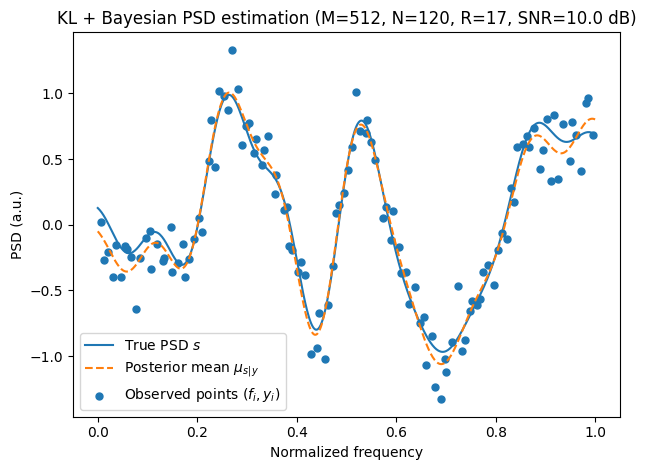

In [9]:
plt.figure()
plt.plot(f, s_true, label="True PSD $s$", linewidth=1.5)
plt.plot(f, s_hat, label="Posterior mean $\mu_{s|y}$", linestyle="--", linewidth=1.5)
plt.scatter(f[I], y, label="Observed points $(f_i,y_i)$", s=25, marker="o")
plt.title(f"KL + Bayesian PSD estimation (M={M}, N={N}, R={R}, SNR={snr_db} dB)")
plt.xlabel("Normalized frequency")
plt.ylabel("PSD (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()

## Pointwise credible band

From $\Sigma_{s|y}=\Phi_{KL}\Sigma_{\xi|y}\Phi_{KL}^\top$, we use its diagonal to form a pointwise band:
$$\mu_{s|y,i} \pm z\,\sqrt{[\Sigma_{s|y}]_{ii}},\quad z=1.96\ (95\%).$$

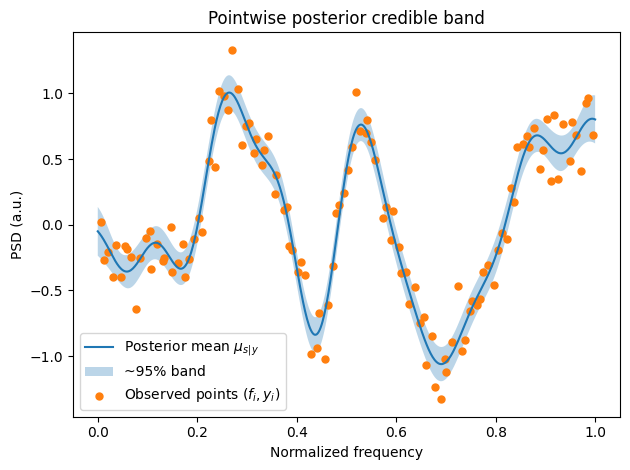

In [10]:
std_s = np.sqrt(np.maximum(diag_Sigma_s, 0.0))
z = 1.96

plt.figure()
plt.plot(f, s_hat, label="Posterior mean $\\mu_{s|y}$", linewidth=1.5)
plt.fill_between(f, s_hat - z*std_s, s_hat + z*std_s, alpha=0.3, label="~95% band")
plt.scatter(f[I], y, label="Observed points $(f_i,y_i)$", s=25, marker="o")
plt.title("Pointwise posterior credible band")
plt.xlabel("Normalized frequency")
plt.ylabel("PSD (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()

## Loading complex IQ data

We are given a complex-valued time-domain signal:
$$
x[n] \in \mathbb{C},\quad n=0,\dots,N_x-1
$$

The KL+Bayesian framework operates on **power spectral density (PSD)** samples,
so we first estimate the PSD on a frequency grid.

This step corresponds to forming an empirical estimate of the latent PSD $s(f)$.


In [43]:
# Load IQ data
x = np.load(r"C:\Users\ASUS\Desktop\kl_psd\Samples 88 and 108MHz,time to read 0.01s, sample #3.npy")
assert np.iscomplexobj(x)

Nx = x.size
print(f"IQ samples: {Nx}, dtype={x.dtype}")

IQ samples: 200000, dtype=complex128


## PSD estimation from IQ samples

We estimate the PSD using a periodogram / Welch method.

Let $\hat{s}(f)$ denote the estimated PSD on a frequency grid
$\{f_i\}_{i=1}^M$.

This $\hat{s}$ plays the role of the *observed PSD* from which we will
subsample measurements according to the model:
$$
y = \Theta s + \varepsilon.
$$


In [44]:
from scipy.signal import welch
# Sampling rate (Hz)
fs = 2.4e6

# Welch PSD
f_hz, Pxx = welch(
    x,
    fs=fs,
    window='hann',
    nperseg=1024,
    noverlap=512,
    nfft=2048,
    return_onesided=False,
    scaling='density'
)

# Shift DC to center
Pxx = np.fft.fftshift(Pxx)
f_hz = np.fft.fftshift(f_hz)

# PSD vector in linear units (THIS is what the KL method should use)
s_psd = np.real(Pxx).copy()
s_psd[s_psd < 0] = 0.0  # numerical guard

# Frequency grid used by KL (M points)
f_grid = f_hz.copy()
M = len(f_grid)

print("Welch grid M =", M)

Welch grid M = 2048


In [45]:
# Quadrature weights (uniform for Welch FFT grid)
# Use Hz spacing (Lebesgue measure in frequency)
df = f_grid[1] - f_grid[0]
w = np.full(M, df)

# Optional normalization of PSD amplitude (doesn't change the method, just scaling)
s_psd = s_psd / (np.mean(s_psd) + 1e-12)



## Using the PSD as the latent field $s$

From this point on, we treat:
$$
s \equiv \hat{s}_{\text{PSD}}
$$

as a noisy realization of the latent PSD.

We now apply **exactly the same KL + Bayesian compression procedure**:
- same frequency grid
- same kernel $k_f$
- same KL truncation criterion
- same inference equations

To emulate subsampled measurements, we select a subset of frequency bins.


In [46]:
rng = np.random.default_rng(0)

N = 200  # number of observed frequency bins (measurements)

I = choose_indices(M, N, rng, mode="jittered")
Theta = make_selection_operator(M, I)

# Measurements from the empirical PSD
y_clean = Theta @ s_psd

# Noise model (optional but consistent)
snr_db = 20.0
sig_pow = np.mean(y_clean**2)
sigma2 = sig_pow / (10**(snr_db / 10))
noise = rng.normal(scale=np.sqrt(sigma2), size=N)
# y = y_clean + noise
y = y_clean


TypeError: choose_indices() got an unexpected keyword argument 'mode'

## Apply KL + Bayesian inference to the measured PSD

We now apply the same inference equations:

$$
\Sigma_{\xi|y} = \left(I + A^\top \Sigma_\varepsilon^{-1} A\right)^{-1},
\quad
\mu_{\xi|y} = \Sigma_{\xi|y} A^\top \Sigma_\varepsilon^{-1} y
$$

with $A = \Theta \Phi_{KL}$, and reconstruct:
$$
\hat{s} = \Phi_{KL} \mu_{\xi|y}.
$$


In [22]:
# Kernel matrix on the Welch frequency grid
K = matern32_kernel_matrix(f_grid, ell=0.08, sigma2=1.0)

# Build eigenspectrum and choose R by cumulative variance criterion
Phi_tmp, lam_tmp, evals_desc, Kw = build_phi_kl(f_grid, w, K, R=min(M, 300))
R, ratio = choose_R_by_cumvar(evals_desc, target=0.97)
print(f"Chosen R={R} (target cum var 0.97)")

# Rebuild Phi_KL with that R
Phi_KL, lam, evals_desc, Kw = build_phi_kl(f_grid, w, K, R=R)

print("Phi_KL shape:", Phi_KL.shape)

Chosen R=1987 (target cum var 0.97)
Phi_KL shape: (2048, 1987)


In [23]:
rng = np.random.default_rng(0)

N = 200  # number of observed bins
I = choose_indices(M, N, rng, mode="jittered")
Theta = make_selection_operator(M, I)

# Measurements y = Θ s + ε
y_clean = Theta @ s_psd

snr_db = 20.0
sig_pow = np.mean(y_clean**2)
sigma2 = sig_pow / (10**(snr_db / 10))
y = y_clean + rng.normal(scale=np.sqrt(sigma2), size=N)

# Safety check (prevents your earlier error)
assert Theta.shape[1] == Phi_KL.shape[0], (Theta.shape, Phi_KL.shape)

mu_xi, Sigma_xi, s_hat, diag_Sigma_s = infer_static(y=y, Theta=Theta, Phi_KL=Phi_KL, sigma2=sigma2)


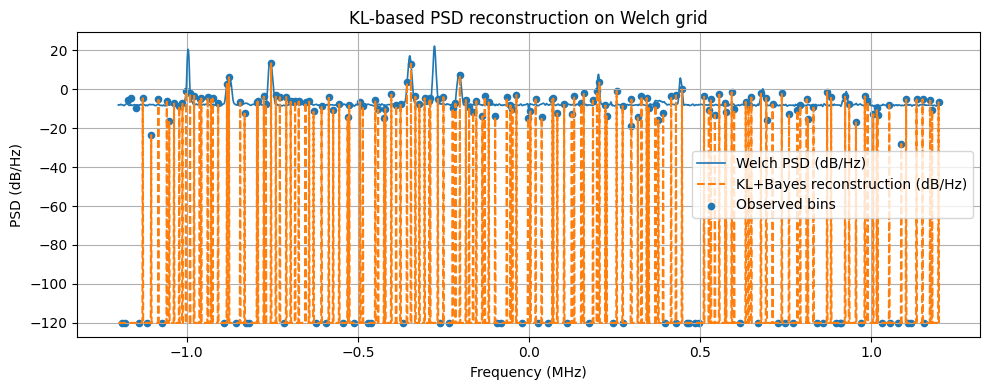

In [24]:
Pxx_dB = 10 * np.log10(s_psd + 1e-12)
s_hat_dB = 10 * np.log10(np.maximum(s_hat, 0.0) + 1e-12)

plt.figure(figsize=(10, 4))
plt.plot(f_grid / 1e6, Pxx_dB, label="Welch PSD (dB/Hz)", linewidth=1.2)
plt.plot(f_grid / 1e6, s_hat_dB, "--", label="KL+Bayes reconstruction (dB/Hz)", linewidth=1.5)

# Observed bins (noisy measurements) plotted in dB
plt.scatter(f_grid[I] / 1e6, 10*np.log10(np.maximum(y, 0.0) + 1e-12), s=20, label="Observed bins")

plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dB/Hz)")
plt.title("KL-based PSD reconstruction on Welch grid")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Wideband PSD Estimation via KL + Bayesian Inference (Real IQ Data)

We are given complex IQ samples:
$$
x[n] \in \mathbb{C}, \quad n = 0,\dots,N_x-1
$$

Our goal is **not** to model the time-domain signal directly, but to estimate
its **power spectral density (PSD)**:
$$
s(f) \ge 0
$$

following the procedure described in the *Wideband PSD Estimation via KL + GP*
document.

Pipeline:

$$
\text{IQ samples}
\;\to\;
\text{Welch PSD}
\;\to\;
\text{KL basis (frequency kernel)}
\;\to\;
\text{Bayesian regression}
\;\to\;
\text{Smoothed PSD + uncertainty}
$$

This is a **static, single-window** version of the method.


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

np.set_printoptions(precision=4, suppress=True)


## Load complex IQ data

The signal is assumed to be complex baseband (IQ).
This allows us to represent both positive and negative frequencies.


In [49]:
# Load IQ data
x = np.load(r"C:\Users\ASUS\Desktop\kl_psd\Samples 88 and 108MHz,time to read 0.01s, sample #3.npy")
assert np.iscomplexobj(x)

Nx = x.size
print(f"IQ samples: {Nx}, dtype={x.dtype}")


IQ samples: 200000, dtype=complex128


## Sampling rate and observable frequencies

Let $f_s$ be the sampling rate (Hz).

For complex IQ signals, the observable frequency range is:
$$
f \in \left[-\frac{f_s}{2},\; +\frac{f_s}{2}\right)
$$

The frequency grid is **determined entirely** by:
- sampling rate $f_s$
- FFT size $N_{\text{FFT}}$


In [50]:
# Sampling rate (Hz)
fs = 2.4e6  # 2.4 MHz


## PSD estimation using Welch’s method

Welch’s method estimates the PSD by:
- segmenting the signal
- windowing
- computing FFTs
- averaging squared magnitudes

This produces a **noisy estimate** of the latent PSD $s(f)$.

Important:
- We use `return_onesided=False` for complex IQ
- We work in **linear units**, not dB, for inference


In [51]:
# Welch PSD
f_hz, Pxx = welch(
    x,
    fs=fs,
    window="hann",
    nperseg=1024,
    noverlap=512,
    nfft=2048,
    return_onesided=False,
    scaling="density"
)

# Shift DC to center
f_hz = np.fft.fftshift(f_hz)
Pxx = np.fft.fftshift(Pxx)

# PSD vector used in the model (linear units)
s_psd = np.real(Pxx).copy()
s_psd[s_psd < 0] = 0.0  # numerical safety

M = len(s_psd)
print("PSD grid size M =", M)


PSD grid size M = 2048


## Frequency grid and quadrature weights

We discretize the PSD on the Welch frequency grid:
$$
s = [s_1,\dots,s_M]^T
$$

Quadrature weights approximate integration over frequency.
For a uniform FFT grid:
$$
w_i = \Delta f
$$


In [52]:
# Frequency grid
f_grid = f_hz

# Quadrature weights
df = f_grid[1] - f_grid[0]
w = np.full(M, df)

# Normalize PSD scale (optional, does not affect structure)
s_psd = s_psd / (np.mean(s_psd) + 1e-12)


## Frequency kernel and prior structure

We assume the PSD varies smoothly across frequency.
This is encoded using a positive definite kernel $k_f(f,f')$.

We use a Matérn $\\nu=3/2$ kernel:
$$
k_f(f,f') = \sigma^2
\left(1 + \\frac{\\sqrt{3}|f-f'|}{\\ell}\right)
\exp\left(-\\frac{\\sqrt{3}|f-f'|}{\\ell}\right)
$$

The length scale $\\ell$ controls how rapidly the PSD can change.

FM signals:
- are **band-limited**
- have smooth spectral envelopes
→ this kernel is appropriate


In [53]:
def matern32_kernel_matrix(f, ell=50e3, sigma2=1.0):
    f = np.asarray(f)
    r = np.abs(f[:, None] - f[None, :])
    a = np.sqrt(3.0) * r / ell
    return sigma2 * (1.0 + a) * np.exp(-a)


## KL basis construction (core compression step)

Define the weighted Gram matrix:
$$
[K_w]_{ij} = k_f(f_i,f_j)\sqrt{w_iw_j}
$$

Compute eigenpairs:
$$
K_w v_n = \lambda_n v_n
$$

Discrete eigenfunctions:
$$
\phi_n(f_i) \approx \frac{[v_n]_i}{\sqrt{w_i}}
$$

KL feature matrix:
$$
[\Phi_{KL}]_{i,n} = \sqrt{\lambda_n}\,\phi_n(f_i)
$$


In [54]:
def build_phi_kl(f, w, K, R):
    sqrtw = np.sqrt(w)
    Kw = (sqrtw[:, None] * K) * sqrtw[None, :]

    evals, evecs = np.linalg.eigh(Kw)
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    lam = np.maximum(evals[:R], 0.0)
    phi = evecs[:, :R] / sqrtw[:, None]
    Phi_KL = phi * np.sqrt(lam)[None, :]
    return Phi_KL, lam, evals


## Choosing the KL rank $R$

The document specifies the criterion:
$$
\frac{\sum_{n=1}^R \lambda_n}{\sum_{n=1}^M \lambda_n} \in [0.95,0.99]
$$

We choose the smallest $R$ meeting this condition.


In [66]:
def choose_R(evals_desc, target=0.97):
    evals_desc = np.maximum(evals_desc, 0.0)
    ratio = np.cumsum(evals_desc) / (np.sum(evals_desc) + 1e-12)
    R = int(np.searchsorted(ratio, target) + 1)
    return R, ratio

K = matern32_kernel_matrix(f_grid, ell=50e3)
Phi_tmp, lam_tmp, evals_desc = build_phi_kl(f_grid, w, K, R=300)
R, ratio = choose_R(evals_desc, target=0.97)

print("Chosen R =", R)

Phi_KL, lam, _ = build_phi_kl(f_grid, w, K, R)


Chosen R = 61


## Measurement model (subsampled PSD bins)

We implement:
$$
y = \Theta s + \varepsilon
$$

by selecting a subset of frequency bins.
This models incomplete / compressed spectral measurements.


In [67]:
def choose_indices(M, N, rng):
    return np.sort(rng.choice(M, size=N, replace=False))

def make_selection_operator(M, I):
    Theta = np.zeros((len(I), M))
    Theta[np.arange(len(I)), I] = 1.0
    return Theta

rng = np.random.default_rng(0)
N = 200

I = choose_indices(M, N, rng)
Theta = make_selection_operator(M, I)

# Measurements
y_clean = Theta @ s_psd

snr_db = 20.0
# sigma2 = np.mean(y_clean**2) / (10**(snr_db/10))
sigma2 = 1e-6
y = y_clean #+ rng.normal(scale=np.sqrt(sigma2), size=N)


## Bayesian inference in KL space

With $A = \Theta \Phi_{KL}$ and $\Sigma_\varepsilon = \sigma^2 I$:
$$
\Sigma_{\xi|y} = \left(I + A^T \Sigma_\varepsilon^{-1} A\right)^{-1}
$$
$$
\mu_{\xi|y} = \Sigma_{\xi|y} A^T \Sigma_\varepsilon^{-1} y
$$

Reconstruction:
$$
\hat{s} = \Phi_{KL}\mu_{\xi|y}
$$


In [68]:
def infer_static(y, Theta, Phi_KL, sigma2):
    A = Theta @ Phi_KL
    R = A.shape[1]

    G = np.eye(R) + (A.T @ A) / sigma2
    b = (A.T @ y) / sigma2

    L = np.linalg.cholesky(G)
    mu_xi = np.linalg.solve(L.T, np.linalg.solve(L, b))

    mu_s = Phi_KL @ mu_xi
    return mu_s

s_hat = infer_static(y, Theta, Phi_KL, sigma2)


## Visualization (PSD in dB/Hz)

We plot:
- Welch PSD
- KL-smoothed PSD
- Observed frequency bins

FM structure should appear as a band-limited hump.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10200\604390298.py:3: RuntimeWarning: invalid value encountered in log10
  plt.plot(f_grid/1e6, 10*np.log10(s_hat + 1e-12), "--", label="KL+Bayes PSD")


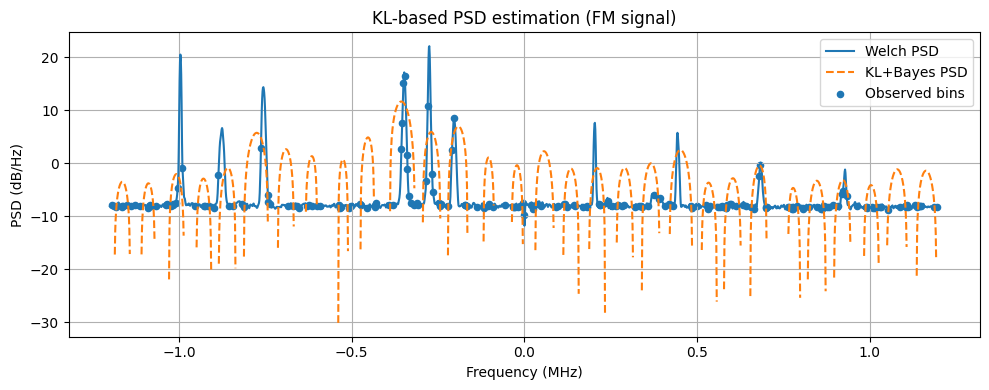

In [69]:
plt.figure(figsize=(10,4))
plt.plot(f_grid/1e6, 10*np.log10(s_psd + 1e-12), label="Welch PSD")
plt.plot(f_grid/1e6, 10*np.log10(s_hat + 1e-12), "--", label="KL+Bayes PSD")
plt.scatter(f_grid[I]/1e6, 10*np.log10(y + 1e-12), s=20, label="Observed bins")

plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dB/Hz)")
plt.title("KL-based PSD estimation (FM signal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
# Single self-contained cell: cross-validate (ell, R via cum-variance target, sigma2 scale),
# fit on train bins, evaluate on held-out bins, then plot best reconstruction + points.

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# REQUIREMENTS / INPUTS
# ----------------------------
# This cell assumes you already have:
#   f_grid : (M,) frequency grid in Hz (from Welch, fftshifted)
#   s_psd  : (M,) PSD in *linear* units (nonnegative), optionally normalized
# If not present, stop here and run your Welch cell first.

assert "f_grid" in globals() and "s_psd" in globals(), "Run Welch cell first to define f_grid and s_psd."
f_grid = np.asarray(f_grid)
s_psd  = np.asarray(s_psd)
M = len(s_psd)
assert len(f_grid) == M

# Quadrature weights (uniform)
df = f_grid[1] - f_grid[0]
w = np.full(M, df)

# ----------------------------
# HELPERS (self-contained)
# ----------------------------
def matern32_kernel_matrix(f, ell, sigma2=1.0):
    f = np.asarray(f)
    r = np.abs(f[:, None] - f[None, :])
    a = np.sqrt(3.0) * r / (ell + 1e-30)
    return sigma2 * (1.0 + a) * np.exp(-a)

def build_phi_kl(f, w, K, R):
    sqrtw = np.sqrt(w)
    Kw = (sqrtw[:, None] * K) * sqrtw[None, :]
    evals, evecs = np.linalg.eigh(Kw)             # ascending
    idx = np.argsort(evals)[::-1]                 # descending
    evals = evals[idx]
    evecs = evecs[:, idx]
    lam = np.maximum(evals[:R], 0.0)
    phi = evecs[:, :R] / sqrtw[:, None]           # phi_n(f_i) ≈ v_n[i]/sqrt(w_i)
    Phi_KL = phi * np.sqrt(lam)[None, :]          # Φ_KL[i,n] = sqrt(lam_n)*phi_n(f_i)
    return Phi_KL, lam, evals

def choose_R_by_cumvar(evals_desc, target=0.97):
    evals_desc = np.maximum(evals_desc, 0.0)
    ratio = np.cumsum(evals_desc) / (np.sum(evals_desc) + 1e-12)
    R = int(np.searchsorted(ratio, target) + 1)
    return R, ratio

def choose_indices_jittered(M, N, rng):
    edges = np.linspace(0, M, N + 1).astype(int)
    I = []
    for k in range(N):
        lo, hi = edges[k], max(edges[k] + 1, edges[k+1])
        I.append(rng.integers(lo, hi))
    I = np.unique(np.array(I, dtype=int))
    if I.size < N:
        missing = N - I.size
        candidates = np.setdiff1d(np.arange(M), I)
        extra = rng.choice(candidates, size=missing, replace=False)
        I = np.sort(np.concatenate([I, extra]))
    else:
        I = np.sort(I)
    return I

def make_selection_operator(M, I):
    Theta = np.zeros((len(I), M))
    Theta[np.arange(len(I)), I] = 1.0
    return Theta

def infer_static(y, Theta, Phi_KL, sigma2):
    # y = Theta * (Phi_KL xi) + eps, eps~N(0,sigma2 I), xi~N(0,I)
    A = Theta @ Phi_KL
    R = A.shape[1]
    G = np.eye(R) + (A.T @ A) / sigma2
    b = (A.T @ y) / sigma2
    L = np.linalg.cholesky(G)
    mu_xi = np.linalg.solve(L.T, np.linalg.solve(L, b))
    mu_s = Phi_KL @ mu_xi
    return mu_s

# ----------------------------
# CROSS-VALIDATION SETUP
# ----------------------------
rng = np.random.default_rng(0)

# Observed bin count N (you can change)
N_obs = 220
I_obs = choose_indices_jittered(M, N_obs, rng)

# Split observed bins into train/test
perm = rng.permutation(N_obs)
n_train = int(0.8 * N_obs)
I_train = np.sort(I_obs[perm[:n_train]])
I_test  = np.sort(I_obs[perm[n_train:]])

# Measurements: use Welch PSD bins directly (no extra synthetic noise)
# This avoids "double-noising" and is best for reconstruction quality.
y_train = s_psd[I_train]
y_test  = s_psd[I_test]

# Hyperparameter grids
# ell in Hz: tune to your band smoothness. These are reasonable defaults for MHz-wide views.
# ell_grid = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
ell_grid = np.array([5e4, 1e5, 2e5, 5e5])
cum_targets = np.array([0.90, 0.95, 0.97, 0.99])

# sigma2 modeled measurement noise: sweep scale relative to Var(y_train)
base_var = np.var(y_train) + 1e-12
sigma_scale_grid = np.array([0.01, 0.03, 0.1, 0.3, 1.0])

best = {"score": np.inf}

# ----------------------------
# GRID SEARCH
# ----------------------------
for ell in ell_grid:
    K = matern32_kernel_matrix(f_grid, ell=ell, sigma2=1.0)
    # get eigen-spectrum once (truncate to speed)
    Phi_tmp, lam_tmp, evals_desc = build_phi_kl(f_grid, w, K, R=min(M, 300))
    for tgt in cum_targets:
        R, ratio = choose_R_by_cumvar(evals_desc, target=tgt)
        R = int(min(R, 300))  # keep computation bounded; adjust if you want
        Phi_KL, lam, _ = build_phi_kl(f_grid, w, K, R=R)

        Theta_train = make_selection_operator(M, I_train)
        Theta_test  = make_selection_operator(M, I_test)

        # Safety check
        assert Theta_train.shape[1] == Phi_KL.shape[0]

        for sscale in sigma_scale_grid:
            sigma2 = base_var * sscale

            # Fit on train
            s_hat = infer_static(y=y_train, Theta=Theta_train, Phi_KL=Phi_KL, sigma2=sigma2)

            # Predict on held-out test bins
            pred_test = s_hat[I_test]

            # Score: NMSE on test bins (linear scale)
            nmse = np.sum((pred_test - y_test) ** 2) / (np.sum(y_test ** 2) + 1e-12)

            if nmse < best["score"]:
                best.update({
                    "score": nmse,
                    "ell": ell,
                    "tgt": tgt,
                    "R": R,
                    "sigma2": sigma2,
                    "Phi_KL": Phi_KL,
                    "s_hat": s_hat
                })

print("Best hyperparams:")


Best hyperparams:


Best hyperparams:
  ell = 1e+05 Hz
  cum_target = 0.95  -> R = 25
  sigma2 = 4.376e+00 (scale=0.03 * Var(train))
  test NMSE = 7.5604e-01


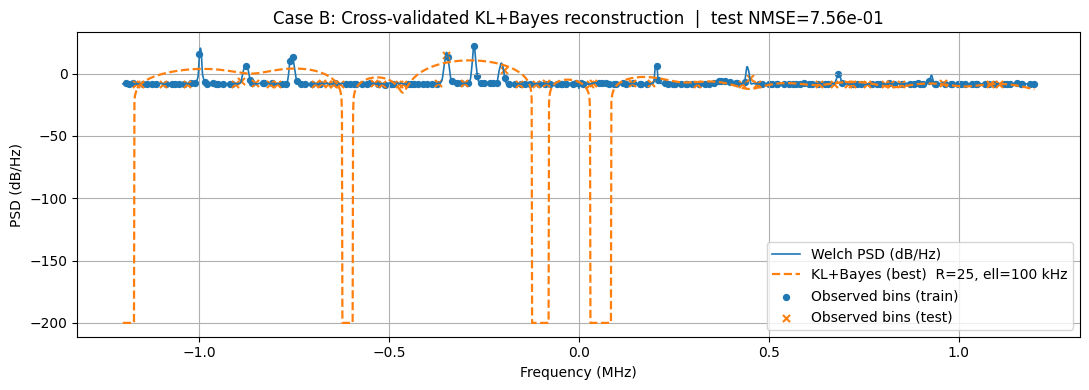

In [65]:
print("Best hyperparams:")
print(f"  ell = {best['ell']:.3g} Hz")
print(f"  cum_target = {best['tgt']:.2f}  -> R = {best['R']}")
print(f"  sigma2 = {best['sigma2']:.3e} (scale={best['sigma2']/base_var:.3g} * Var(train))")
print(f"  test NMSE = {best['score']:.4e}")

# ----------------------------
# PLOT RESULTS
# ----------------------------
s_hat = best["s_hat"]
# dB for visualization (clip to avoid -inf)
welch_dB = 10*np.log10(np.maximum(s_psd, 1e-20))
hat_dB   = 10*np.log10(np.maximum(s_hat, 1e-20))
train_dB = 10*np.log10(np.maximum(s_psd[I_train], 1e-20))
test_dB  = 10*np.log10(np.maximum(s_psd[I_test], 1e-20))

plt.figure(figsize=(11,4))
plt.plot(f_grid/1e6, welch_dB, label="Welch PSD (dB/Hz)", linewidth=1.2)
plt.plot(f_grid/1e6, hat_dB, "--", label=f"KL+Bayes (best)  R={best['R']}, ell={best['ell']/1e3:.0f} kHz", linewidth=1.6)

plt.scatter(f_grid[I_train]/1e6, train_dB, s=18, marker="o", label="Observed bins (train)")
plt.scatter(f_grid[I_test]/1e6,  test_dB,  s=26, marker="x", label="Observed bins (test)")

plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dB/Hz)")
plt.title(f"Case B: Cross-validated KL+Bayes reconstruction  |  test NMSE={best['score']:.2e}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()